<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Multi/Multi_HRHN_NASDAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [ ]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.70.2.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.2.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Le dataset utilisé contient les prix des actions des 81 principales compagnies du NASDAQ100. La valeur de l'index du NASDAQ est utilisé comme cible.  
La fréquence des information est d'une minute, depuis le 26 juillet 2016 jusqu'au 22 décembre 2016, soit 105 jours au total (les samedi et dimanche ne sont pas comptés, ainsi que le 25 novembre qui ne possède que 210 données et le 22 décembre qui n'en possède que 180).

**1. Chargement des données**

In [ ]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/nasdaq100_padding.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   184  100   184    0     0   1150      0 --:--:-- --:--:-- --:--:--  1150
100 22.6M  100 22.6M    0     0  16.6M      0  0:00:01  0:00:01 --:--:-- 22.6M


**2. Analyse et correction des données**

In [ ]:
# Création de la série sous Pandas
df_etude = pd.read_csv("nasdaq100_padding.csv",dtype="float32")
df_etude

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,AMZN,ATVI,AVGO,BBBY,BIDU,BIIB,CA,CELG,CERN,CMCSA,COST,CSCO,CSX,CTRP,CTSH,DISCA,DISH,DLTR,EA,EBAY,ESRX,EXPE,FAST,FB,FOX,FOXA,GILD,GOOGL,INTC,JD,...,LBTYK,LRCX,MAR,MAT,MCHP,MDLZ,MSFT,MU,MXIM,MYL,NCLH,NFLX,NTAP,NVDA,NXPI,PAYX,PCAR,PYPL,QCOM,QVCA,ROST,SBUX,SIRI,STX,SWKS,SYMC,TMUS,TRIP,TSCO,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.980000,96.800003,97.800003,61.150002,95.400002,58.180000,58.000000,127.040001,26.680000,165.809998,742.119995,42.299999,161.410004,44.209999,159.889999,286.320007,34.570000,106.050003,62.070000,67.339996,167.600006,30.790001,28.370001,43.520000,58.400002,25.420000,52.439999,96.550003,76.949997,30.600000,76.540001,117.879997,41.990002,121.940002,27.500000,26.860001,84.000000,756.570007,34.770000,21.799999,...,30.209999,91.239998,71.110001,32.779999,54.779999,45.689999,56.514999,14.000000,39.200001,47.130001,41.900002,91.000000,26.440001,56.198399,85.230003,60.740002,56.169998,37.770000,60.950001,26.740000,61.130001,58.578999,4.280,31.350000,65.360001,20.370001,44.950001,70.050003,91.410004,227.649994,70.730003,45.230000,31.170099,95.269997,81.364998,52.160000,33.950001,48.610001,38.009998,4665.054199
1,35.931000,96.889999,97.800003,61.610001,95.411499,58.189999,58.119999,126.059998,26.730000,165.910095,741.919983,42.439999,161.830002,44.090000,160.130005,286.809998,34.580002,105.544998,61.930000,67.300003,167.820007,30.840000,28.462500,43.520000,58.330002,25.410000,52.110001,96.820000,77.070000,30.740000,76.440002,117.989998,41.900002,121.745003,27.480000,26.870001,83.970001,756.159973,34.919998,21.850000,...,30.430000,91.330002,70.849998,32.790001,54.889999,45.730000,56.720001,14.000000,39.369999,47.150002,41.810001,91.160004,26.450001,56.415001,86.175003,60.935001,56.849998,37.740002,60.919998,26.719999,61.430000,58.480000,4.270,31.010000,65.250000,20.410000,44.974998,70.230003,91.050003,227.096695,70.690002,45.009998,31.190001,94.169998,81.540001,52.150002,34.099998,48.740002,38.139999,4665.054199
2,35.904400,96.949997,97.570000,61.980000,95.510002,58.203335,57.950001,126.510002,26.712000,166.179993,739.599976,42.459999,162.500000,43.860001,160.000000,286.130005,34.590000,106.578697,61.916668,67.230003,167.960007,30.879999,28.389999,43.540001,58.340000,25.379999,52.106667,96.889999,77.250000,30.799999,76.089996,118.629997,41.735001,121.452003,27.410000,26.820000,84.000000,755.619995,34.919201,21.770000,...,30.170000,91.370003,70.779999,32.830002,55.139999,45.799999,56.700001,14.005600,39.380001,47.130001,41.865002,91.360001,26.389999,56.490002,85.680099,61.000000,57.500000,37.711700,61.029999,26.660000,61.549999,58.509998,4.285,31.195000,65.410004,20.389999,44.810001,70.092499,91.180000,226.630005,71.300003,45.014999,31.209999,94.749001,81.529999,52.270000,34.009998,48.990002,38.150002,4665.826172
3,35.889999,96.970001,97.550003,62.090000,95.519997,58.216667,57.959999,126.279999,26.740000,166.147995,739.549988,42.520000,162.679993,43.799999,160.119995,286.799988,34.610001,106.349998,61.903332,67.379997,167.850006,30.889999,28.389999,43.549999,58.540001,25.370001,52.103333,96.760002,76.959999,30.860001,75.650002,118.570000,41.709999,121.449997,27.420000,26.870001,83.339996,756.359924,34.951000,21.809999,...,30.100000,91.419998,70.875000,32.860001,55.310001,45.790001,56.689999,14.057300,39.419998,47.115002,41.919998,92.279999,26.395500,56.533501,85.665001,61.007999,57.750000,37.825001,61.130001,26.730000,61.500000,58.470001,4.280,31.139999,65.239998,20.370001,44.689999,69.955002,91.279999,227.529999,71.309998,45.020000,31.209999,94.309998,81.709999,52.299999,33.959999,48.950001,38.195000,4667.081055
4,36.007999,96.959999,97.730003,61.889999,95.529999,58.230000,58.209999,126.584999,26.719999,165.990005,738.719971,42.610001,162.750000,43.919998,160.860001,286.420013,34.619999,106.000000,61.889999,67.300003,168.440002,30.875000,28.389999,43.630001,58.560001,25.320000,52.099998,96.760002,77.029999,30.889999,76.500000,118.419998,41.820000,121.379997,

Affiche les types :

In [ ]:
df_etude.dtypes

AAL     float32
AAPL    float32
ADBE    float32
ADI     float32
ADP     float32
         ...   
WDC     float32
WFM     float32
XLNX    float32
YHOO    float32
NDX     float32
Length: 82, dtype: object

**5. Affiche les données**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['NDX'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [ ]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 32448
Taille de la validation : 8112


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [ ]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [ ]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(32448, 82)
(8112, 82)


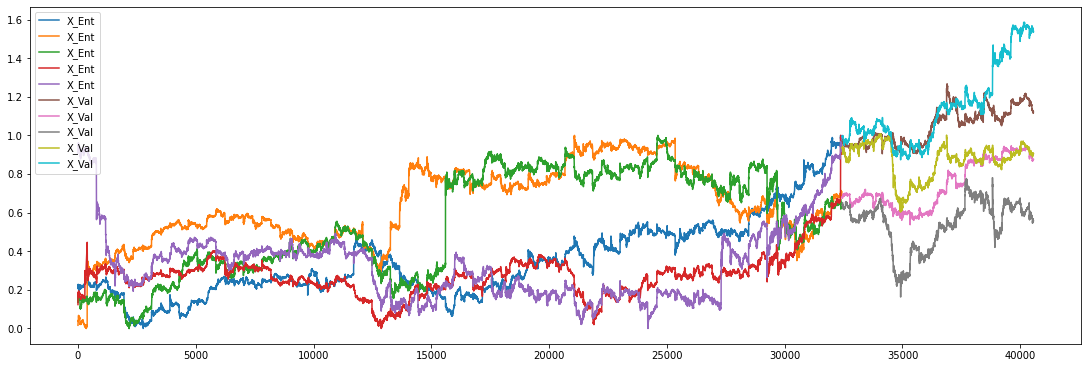

In [ ]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://raw.githubusercontent.com/AlexandreBourrieau/FICHIERS/main/Series_Temporelles/Multi/images/DatasetDARNN.bmp' width=500/>

**1. Exemple de dataset**

In [ ]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,1,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(1):
  print(element)

(100, 3)
90
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 9, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.]]])>), <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[310.]]])>)


**2. Préparation des datasets**

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 10
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT-1)
  print(element[1].shape)               # YT

253
(128, 10, 81)
(128, 9, 1)
(128, 1, 1)


In [ ]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT-1
  print(element[1].shape)               # YT

63
(128, 10, 81)
(128, 9, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [ ]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(32384, 10, 81)
(32384, 9, 1)
(32384, 1, 1)


In [ ]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(8064, 10, 81)
(8064, 9, 1)
(8064, 1, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[0][0,:,0:3],label="X_train (X)")
ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence-1),x_train[1][0,:,:],label="X_train (Y)")

ax.plot(np.linspace(longueur_sequence,longueur_sequence+1,1),y_train[0,:,:],label="Y_train",marker="*")

ax.legend()
plt.show()

# Création de la couche RHN avec Dropout Variationnel

Le modèle RHN (Recurrent Highway Network) implanté est le suivant. Le document de recherche associé est consultable ici : [Recurrent Highway Networks
](https://arxiv.org/pdf/1607.03474)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Structure_RHN3.png?raw=true'>

On intègre le dropout variationnel expliqué dans le papier de recherche suivant : [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/pdf/1512.05287.pdf)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DropoutVariationnem.png?raw=true' width=800>

**1. Création d'une cellule RHN**

On commence par créer une cellule RHN (de taile L couches) qui sera appelée T fois (T est le nombre d'instants) par la suite.

In [ ]:
class Cellule_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.dim_input = 1
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wh = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wh")       # (#dim, #RHN)
    self.Wt = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wt")       # (#dim, #RHN)
    self.Wc = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wc")       # (#dim, #RHN)

    self.Rh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rh")      # (n_couches,#RHN, #RHN)
    self.Rt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rt")      # (n_couches,#RHN, #RHN)
    self.Rc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rc")      # (n_couches,#RHN, #RHN)

    self.bh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bh")        # (n_couches,#RHN, 1)
    self.bt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bt")        # (n_couches,#RHN, 1)
    self.bc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bc")        # (n_couches,#RHN, 1)

    super().build(input_shape)        # Appel de la méthode build()

    # Initialisation des masques de dropout
  def InitMasquesDropout(self,drop=0.0):
    self.Wh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Rh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)   # (n_couches,#RHN,1)

  # Entrées :
  #     input:          Entrées X[t]        : (batch_size,1,#dim)
  #     init_hidden:    Etat caché Init.    : (batch_size,#RHN)
  # Sorties :
  #     sL:             Etat caché SL[t]    : (batch_size,#RHN)
  def call(self, input,init_hidden=None):
    # Construction d'un vecteur d'état nul si besoin
    if init_hidden == None:
      init_hidden = tf.matmul(tf.zeros(shape=(self.dim_RHN,input.shape[2])), # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
                              tf.transpose(input,perm=[0,2,1]))
      init_hidden = tf.squeeze(init_hidden,-1)                               # (batch_size,#RHN,1) => (batch_size,#RHN)
    
    # Calcul de hl, tl et cl
    for i in range(self.nbr_couches):
      if i==0:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[0,:,:],self.Rh[0,:,:])                      # (#RHN,1)_x_(#RHN,#RHN)
        Rt = tf.multiply(self.Rt_[0,:,:],self.Rt[0,:,:])
        Rc = tf.multiply(self.Rc_[0,:,:],self.Rc[0,:,:])

        Wh = tf.multiply(self.Wh_,self.Wh)
        Wt = tf.multiply(self.Wt_,self.Wt)
        Wc = tf.multiply(self.Wc_,self.Wc)
   
        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = hl + tf.matmul(tf.transpose(Wh),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tl + tf.matmul(tf.transpose(Wt),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = cl + tf.matmul(tf.transpose(Wc),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)

      else:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[i,:,:],self.Rh[i,:,:])
        Rt = tf.multiply(self.Rt_[i,:,:],self.Rt[i,:,:])
        Rc = tf.multiply(self.Rc_[i,:,:],self.Rc[i,:,:])

        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)
      
      # Calcul de sl
      sl = tf.keras.layers.multiply([hl,tl])
      sl = sl + tf.keras.layers.multiply([init_hidden,cl])
      init_hidden = sl

    return sl

**2. Création de la couche RHN**

Cette couche prend en entrée un tenseur au format (batch_size,Tin,#RHN) puis retourne une sortie au format (batch_size,#RHN) si `return_sequence=False` ou au format (batch_size,Tin,#RHN) si `return_sequence=True`.

In [ ]:
class Couche_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches, dropout=0.0, return_sequence=False):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.return_sequence = return_sequence
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  #     init_hidden:    Etat caché Init.  : (batch_size,#RHN)
  # Sorties :
  #     y:              Dernier Sl        : (batch_size,#RHN)
  #            (ou)     Séquence entière  : (batch_size,Tin,#RHN)
  def call(self, input, init_hidden=None):
    sequence = []
    hidden = init_hidden

    # Initialisation des masques de dropout pour tous les pas de temps
    self.RHN.InitMasquesDropout(self.dropout)

    # Applique la cellule RHN à chaque pas de temps
    for i in range(input.shape[1]):
      hidden = self.RHN(input[:,i:i+1,:],hidden)      # Envoie (batch_size,1,#dim)
      sequence.append(hidden)                         # Sauve (batch_size,#RHN)
    
    if self.return_sequence == False:
      return hidden
    else:
      sequence = tf.convert_to_tensor(sequence)       # (Tin,batch_size,#RHN)
      sequence = tf.transpose(sequence,perm=[1,0,2])  # (batch_size,Tin,#RHN)
      return sequence

# Création du modèle HRHN

In [ ]:
x_train[0].shape

(32384, 10, 81)

In [ ]:
inp = x_train[0][:,0:1,0:80]
inp = tf.transpose(inp,perm=[0,2,1])
inp.shape

TensorShape([32384, 80, 1])

In [ ]:
res = tf.keras.layers.Conv1D(filters=16,kernel_size=3,activation='relu',padding='same',strides=1)(inp)
res.shape

TensorShape([32384, 80, 16])

In [ ]:
convs = []
input_cnns = []

for i in range(inp.shape[1]):
  input_cnns.append(tf.keras.Input(shape=(81,1)))

for i in range(5):
  conv = tf.keras.layers.Conv1D(filters=16,kernel_size=3,activation='relu',padding='same',strides=1)(input_cnns[i])
  conv = tf.keras.layers.MaxPool1D(pool_size=3,padding='same')(conv)
  conv = tf.keras.layers.Conv1D(filters=32,kernel_size=3,activation='relu',padding='same',strides=1)(conv)
  conv = tf.keras.layers.MaxPool1D(pool_size=3,padding='same')(conv)
  conv = tf.keras.layers.Conv1D(filters=64,kernel_size=3,activation='relu',padding='same',strides=1)(conv)
  conv = tf.keras.layers.MaxPool1D(pool_size=3,padding='same')(conv)
  convs.append(conv)

out = tf.convert_to_tensor(convs)
out = tf.transpose(out,perm=[1,0,2,3])
print(out.shape)
out = tf.keras.layers.Reshape(target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)
print(out.shape)
out = tf.keras.layers.Dense(units=10)(out)
print(out.shape)

conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

(None, 5, 3, 64)
(None, 5, 192)
(None, 5, 10)


In [ ]:
conv_model.summary()

**1. Création de l'encodeur**

***Création des CNN parallèlisés***

In [ ]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]

class Encodeur_CNN(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling,dim_motif):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    super().__init__()                # Appel du __init__() de la classe Layer
  
  # Création de Tin réseaux de convolution + max_pooling en //
  ############################################################
  def build(self,input_shape):
    convs = []
    input_cnns = []

    # Création des Tin entrées des réseaux CNN
    for i in range(input_shape[1]):
        input_cnns.append(tf.keras.Input(shape=(input_shape[2],1)))       # input = Tin*(batch_size,#dim,1)

    # Création des Tin réseaux CNN
    for i in range(inp.shape[1]):
      conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[0],      # conv : (batch_size,#dim,16)
                                    kernel_size=self.dim_filtres_cnn[0],
                                    activation='relu',
                                    padding='same',
                                    strides=1)(input_cnns[i])
      conv = tf.keras.layers.MaxPool1D(pool_size=dim_max_pooling[0],      # conv : (batch_size,#pooling1,16)
                                       padding='same')(conv)
      for n in range(1,len(self.dim_filtres_cnn)):
        conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                      kernel_size=self.dim_filtres_cnn[n],
                                      activation='relu',
                                      padding='same',
                                      strides=1)(conv)
        conv = tf.keras.layers.MaxPool1D(pool_size=dim_max_pooling[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                         padding='same')(conv)
      convs.append(conv)
    
    # Création de la sortie concaténée des Tin réseaux CNN
    out = tf.convert_to_tensor(convs)                                     # out : (Tin,batch_size,#pooling,64)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,Tin,#pooling,64)
    out = tf.keras.layers.Reshape(                                        # out : (batch_size,Tin,#pooling*64)
        target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)

    out = tf.keras.layers.Dense(units=self.dim_motif)                     # out : (batch_size,Tin,dim_motif) 

    # Création du modèle global
    self.conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:  Entrée séries exogènes  : (batch_size,Tin,#dim)
  # Sorties :
  #     w:      Sorties des motifs CNN  : (batch_size,Tin,#pooling,64)
  #                                       (taille dernier filtre=64)
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.conv_model(input)                                            # (batch_size,Tin,dim_motif)
    return w

***Création de l'encodeur***

In [ ]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]
#   dim_motif         :   dimension du motif en sortie du CNN
#   dropout           :   dropout variationnel pour le RHN ex: [0.1]

class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling, dim_motif,dropout=0.0):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.encodeur_cnn = Encodeur_CNN(dim_filtres_cnn=self.dim_filtres_cnn,nbr_filtres_cnn=self.nbr_filtres_cnn,dim_max_pooling=self.dim_max_pooling,dim_motif=self.dim_motif)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  # Sorties :
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.encodeur_cnn(input)      #  (batch_size,Tin,dim_motif)
    return w

**2. Création de la couche d'encodeur à base de LSTM**

**2. Création de la couche d'attention du décodeur**

**3. Création de la couche de décodeur**

**4. Création de la couche réseau**

**4. Création du modèle**

In [ ]:
dim_LSTM = 128
drop=0.0
l2reg=0.0

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence-1,1))

  encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

  sortie = Net_DARNN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_LSTM=dim_LSTM,regul=l2reg,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement avec TPU

In [ ]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.001)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Chargement du modèle pré-entrainé

**DA-RNN128_DR0_L2_0_BS128_EP500_10**  

  - Vecteur LSTM : 128  
	- Longueur entrée : 10  
	- Longueur sortie : 1
	- Drop : 0.0
	- L2 : 0.00  
	- Batch Size : 128  
	- Périodes : 500   
	=> mse :  2.2493e-05 / 2.8063e-04
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Train_DARNN2.png?raw=true' width=500/>

In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/DA-RNN128_DR0_L2_0_BS128_EP500_10.hdf5"

In [ ]:
model.load_weights("DA-RNN128_DR0_L2_0_BS128_EP500_10.hdf5")

# Prédictions single-step

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)